In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 
df_btc = pd.read_csv('../data/webdata/Gemini_BTCUSD_d.csv',skiprows=1)
df_btc.rename(columns={'Open': 'price_open', 'High': 'price_high', 'Low': 'price_low', 'Close': 'price_close', 'Volume BTC':'volume_traded','Date':'time_close'},inplace=True)

In [11]:

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.datagen as dg
data=dg.IndexedData("","",df_btc)
config = {'asset_type': 'spot'}
model_btc = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', data, config)
comp_btc.data=comp_btc.data.sort_index()

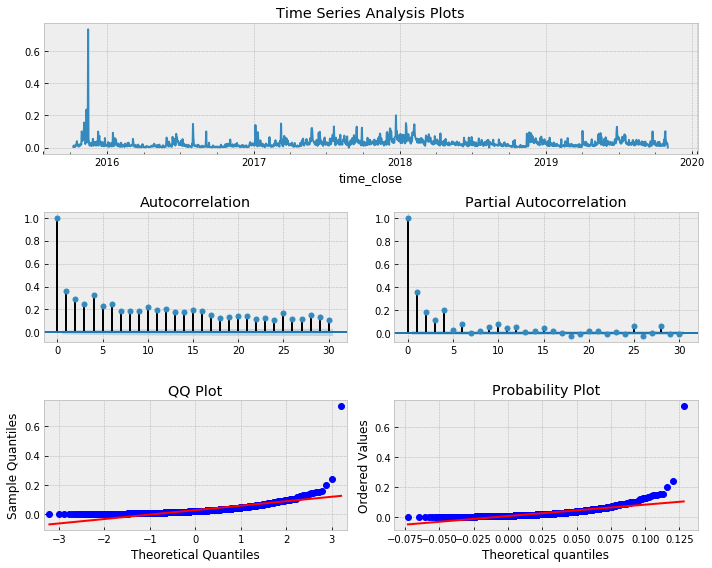

In [13]:
tsplot(comp_btc.data['range_high'], lags=30)

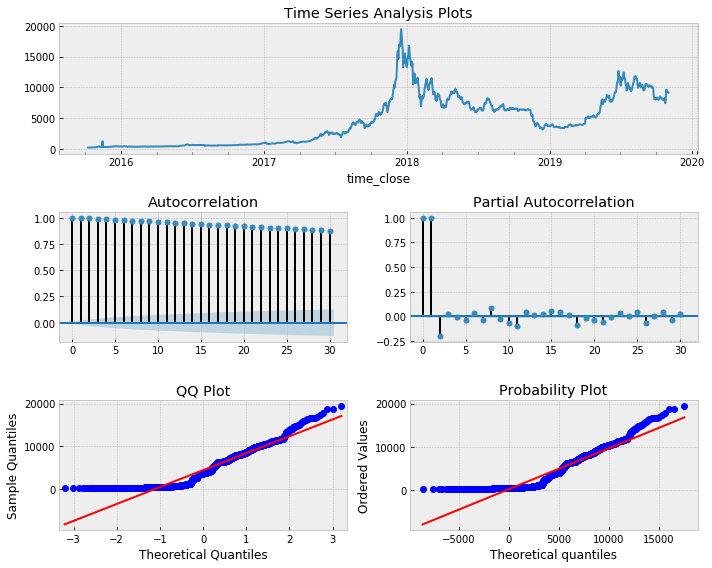

In [15]:
tsplot(comp_btc.data['price_mid'], lags=30)

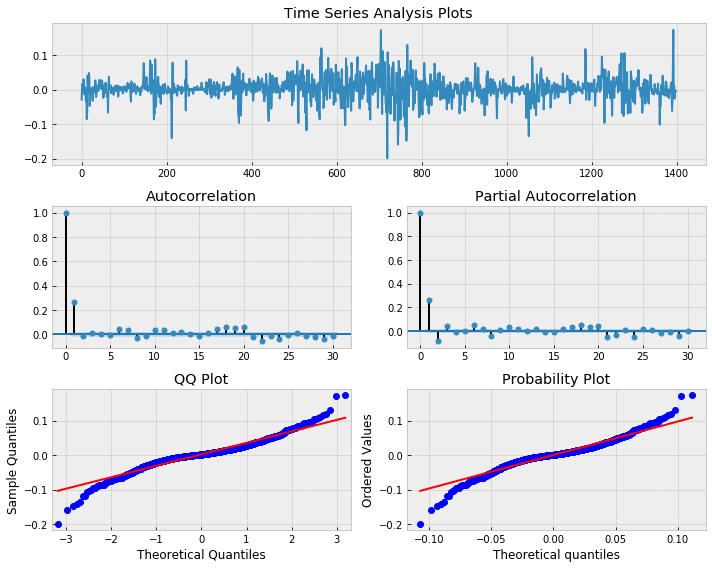

In [25]:
temp=comp_btc.data.loc[comp_btc.data.index > datetime.strptime('2016-01-01', '%Y-%m-%d')]['price_mid']
logret_btc=np.diff(np.log(temp.as_matrix()))
tsplot(logret_btc,lags=30)

aic: -5662.60014 | order: (2, 0, 3)


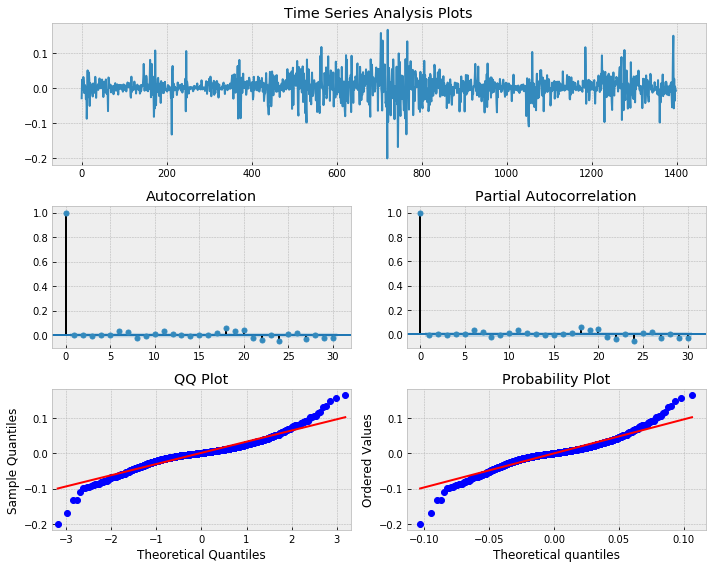

In [27]:
# Fit ARIMA(p, d, q) model 
# pick best order and final model based on aic
import warnings
warnings.filterwarnings('ignore')

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(29) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(logret_btc, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                3044.30
Distribution:      Standardized Student's t   AIC:                          -6072.59
Method:                  Maximum Likelihood   BIC:                          -6030.65
                                              No. Observations:                 1399
Date:                      Mon, Nov 04 2019   Df Residuals:                     1391
Time:                              12:10:41   Df Model:                            8
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

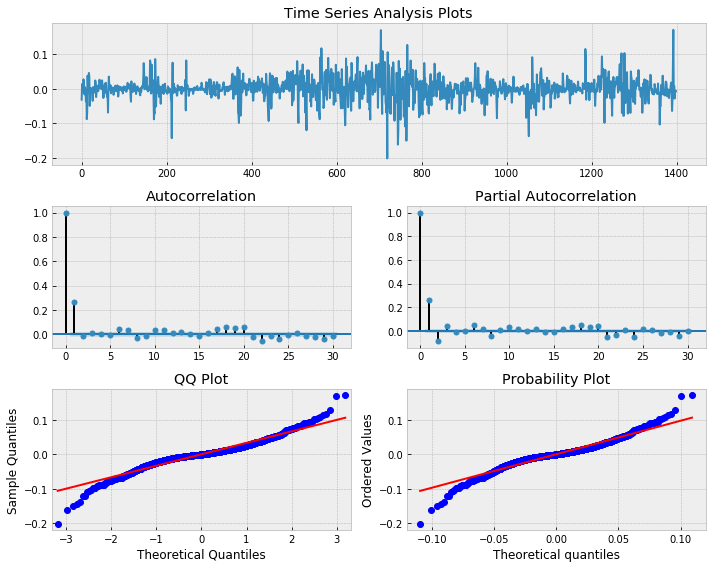

In [28]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(logret_btc, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

_ = tsplot(res.resid, lags=30)

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


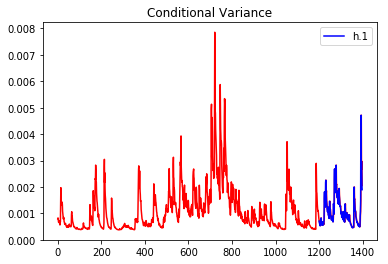

In [29]:
split_date=1200
res_f = am.fit(update_freq=5, disp='off',last_obs=split_date)
forecasts = res_f.forecast(start=split_date)

fig, ax = plt.subplots(1,1)
#res.conditional_volatility
pd.Series(res.conditional_volatility ** 2.0).plot(ax=ax, title='Conditional Variance',color='red')
plt.hold('on')
forecasts.variance[split_date:].plot(ax=ax,color='blue')